# Survival Models

Survival models, also known as time-to-event models, are specialized statistical methods designed to analyze the time until the occurrence of an event of interest. In this notebook, a review of survival analysis  and censored data is provided, followed by a survival model implementation in Bambi.

## Survival and censoring times

Sometimes the right way to model discrete, countable events is to model not the counts themselves but rather the **time between events**. This gives us information regarding the rate of an event. Survival models are models for countable things, but the outcomes we want to predict are durations. Durations are continuous deviations from some point of reference (so they are all positive values). 

The tricky part with survival models is not the probability distribution assigned to the durations, but dealing with censoring. Censoring occurs when the event of interest does not occur in the window of observation. In a simple scenario, this can happen because the observation period ends before the event occurred. Censored individuas (or units) can not just be dropped from the sample. Imagine a cohort of 100 cats who start waiting for adoption at the same time. After one month, half of them have been adopted. Now what is the rate of adoption? You can’t compute it using only the cats who have been adopted. You need to also account for the cats who haven’t yet been adopted. The cats who haven’t been adopted yet, but eventually will be adopted, clearly have longer waiting times than the cats who have already been adopted. So the average rate among those who are already adopted is biased upwards—it is confounded by conditioning on adoption.

Including censored observations requires a new type of model. The key idea is that the same distribution assumption for the outcome tells us both the probability of any observed duration that end in the event as well as the probability that we would wait the observed duration without seeing the event. For each unit, we assume there is a true _survival time_ $T$ as well as a true censoring time $C$. The survival time represents the time at which the event of interest occurs. The censoring time is the time at which censoring occurs. We observe either: the survival, or the censoring time:

$$Y = \text{min}(T, C)$$

If the event occurs, then we observe the survival time, else we observe the censoring time. In order to analyze survival data, we first need to understand the two types of censoring: left and right censoring, and how to estimate the survival function.

## Left and right censoring

There are two main "types" of censoring: right and left. Right sensoring occurs when $T \ge Y$, i.e. the true event time $T$ is at least as large as the observed time $Y$. This is a consequence of $Y = \text{min}(T, C)$. Right censoring derives its name from the notion that time is typically read and displayed from left to right. Left sensoring occurs when the true event time $T$ is less than or equal to the observed time $Y$. An example of left censoring could be in a study of pregnancy duration, suppose that patients are surveyed 250 days (8.2 months) after conception. Some patients may have already had their babies. For these patients, pregnancy duration is **less than** 250 days.

## Estimating the survival function

Survival analysis is concerned with estimating the survival function $S(t)$

$$S(t) = Pr(T > t) = 1 - F(t)$$

which is a decreasing function that quantifies the probability of surviving past time $t$. Alternatively, $S(t)$ can be expressed as one minus the cumulative distribution function (CDF) $F$ of the event time $T$—referred to as the complementary cumulative distribution function (CCDF). The focus on the survival function is important because for censored observations, we only know that the time-to-event exceeds the observed time $Y$.

Here, continuing with the cat adoption example, we consider the task of estimating the survival function for cat adoptions. To estimate $S(30) = Pr(T > 30)$, the probability that a cat is not adopted after 30 days, it is tempting to compute the proportion of cats who were adopted before 30 days and subtract this from 1. However, this would be incorrect because it ignores the cats who were not adopted before 30 days but who **will be** adopted later—these cats clearly have longer adoption rates. Thus, if we continued with the naive approach, the average rate of adoption would be biased upwards—it is confounded by conditioning on adoption.

However, it is possible to overcome this challenge by using the Kaplan-Meier estimator. The Kaplan-Meier estimator is a non-parametric estimator of the survival function that accounts for censoring. Let $d_1 < d_2 < . . . < d_K$ denote the $K$ unique adoption times among the non-censored cats, and $q_k$ denote the number of cats adopted at time $d_k$. For $k = 1,...,K$, let $r_k$ denote the number of cats not adopted at time $d_k$. By the law of total probability

$$Pr(T > d_k) = Pr(T > d_k | T > d_{k-1}) Pr(T > d_{k-1}) + Pr(T > d_k | T \leq d_{k-1}) Pr(T \leq d_{k-1})$$

The fact that $d_{k-1} < d_k$ implies that $Pr(T > d_k | T \leq d_{k-1}) = 0$ (as it is impossible for a cat to be adopted past time $d_k$ if the cat was adopted before time $d_{k-1}$). Thus, if we simplify the above equation and plug into the survival function, we obtain

$$S(d_k) = Pr(T > d_k | T > d_{k-1})S(d_{k-1})$$

Now we must estimate the terms on the right-hand side. It is common to use the following estimator 

$$\hat{Pr}(T > d_j | T > d_{j-1}) = \frac{r_j - q_j}{r_j}$$

which leads us to the Kaplan-Meier estimator of the survival function

$$\hat{S}(d_k) = \prod_{j=1}^k \frac{r_j - q_j}{r_j}$$

Below is a Python function implementing the Kaplan-Meier estimator to estimate the survival function for cat adoptions.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import seaborn.objects as so

import bambi as bmb

%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/AustinCats.csv"
cats = pd.read_csv(url, sep=";")

cats_new = cats.copy()
cats_new["adopt"] = np.where(cats_new["out_event"] == "Adoption", "right", "none")
cats_new["color_id"] = np.where(cats_new["color"] == "Black", 1, 0)
cats_new = cats_new[["days_to_event", "adopt", "color_id"]]

cats_sample = cats_new.sample(5000, random_state=42)

In [59]:
cats_new

,days_to_event,adopt,color_id
0,1,none,0
1,25,none,0
2,4,right,0
3,41,none,0
4,9,none,0
...,...,...,...
22351,10,none,0
22352,5,none,0
22353,6,none,0
22354,9,none,0


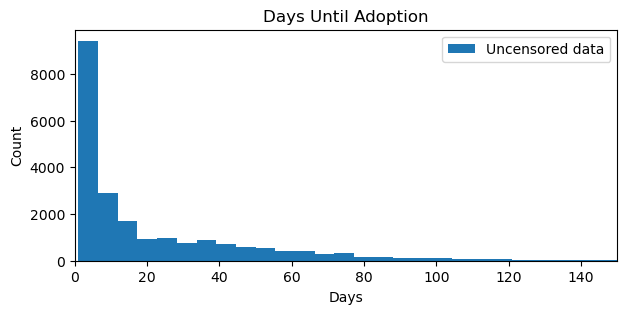

In [60]:
plt.figure(figsize=(7, 3))
plt.hist(cats_new["days_to_event"], bins=250, label="Uncensored data")
plt.xlim(0, 150) # truncate for visibility
plt.title("Days Until Adoption")
plt.ylabel("Count")
plt.xlabel("Days")
plt.legend();

In [61]:
def kaplan_meier_estimator(d_k, d, times):
    """
    Compute the Kaplan-Meier estimator.

    Parameters:
    -----------
    - d_k: np.ndarray
        Array of unique observed event times.
    - d: np.ndarray
        Array indicating if the event occurred at the time from the 'd_k' list;
        True if event occurred, False if censored.
    - times: np.ndarray
        Array of times at which the survival function should be evaluated.

    Returns:
    --------
    - List of Kaplan-Meier estimates at the specified 'times'.
    """

    n = len(d_k)
    survival = []
    s_prev = 1

    for time in times:
        product = s_prev
        for i in range(n):
            if d_k[i] <= time:
                product *= (1 - d[i] / (n - i))
        survival.append(product)
        s_prev = product

    return survival

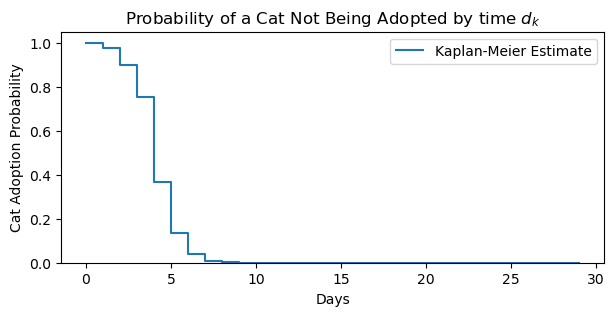

In [63]:
observed_adoption_times = cats_new[cats_new["adopt"] == "right"]["days_to_event"].values
adoption = (cats_new["adopt"] == "right").values
evaluation_times = np.arange(0, 30, 1)
adoption_km_estimates = kaplan_meier_estimator(
    observed_adoption_times, adoption, evaluation_times
)

plt.figure(figsize=(7, 3))
plt.step(evaluation_times, adoption_km_estimates, where="post", label="Kaplan-Meier Estimate")
plt.xlabel("Days")
plt.ylabel("Cat Adoption Probability")
plt.title("Probability of a Cat Not Being Adopted by time $d_k$")
plt.ylim(0, 1.05)
plt.legend()
plt.show()

## Regression models with a survival response

It is often the case that we would like to understand how various predictors are associated with the survival function. For example, we may want to know if the survival function for cats of different colors or species is different. As outlined above, we cannot simply run a regression on the observed times $Y$ given some predictors $X$. What we are actually interested in is predicting the survival time $T$ given the predictors $X$. To achieve this, Bambi utilizes the [censored distribution](https://www.pymc.io/projects/docs/en/latest/api/distributions/censored.html) from PyMC which allows us to make use of a sequential construction, similar to the Kaplan-Meier estimator outlined above. To understand how the censored distribution allows us to fit regression models with survival responses, we first need to understand the Hazard function and the Cox proportional hazards model.

### The Hazard function

The hazard function is defined as the instantaneous rate of an event occuring at time $t$ given that the event has not yet occured. The hazard function is defined as

$$h(t) = \lim_{\Delta t \rightarrow 0} \frac{Pr(t \leq T < t + \Delta t | T \geq t)}{\Delta t}$$

where $T$ is the (unobserved) survival time. The Hazard function is closely related to the survival function $S(t)$, and it is a key approach for modeling survival data as a function of predictors. However, it is typical to phrase the model in terms of the cumulative hazard function

$$\Lambda(t) = -\text{log} S(t)$$


### The Cox proportional hazards model

Above, we used the Kaplan-Meier estimator to estimate the survival function for cat adoptions. However, since we would now like to add predictor(s), a risk regression model is more appropriate. 

### The censored distribution

...

## Implementation in Bambi

### Cat adoptions

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


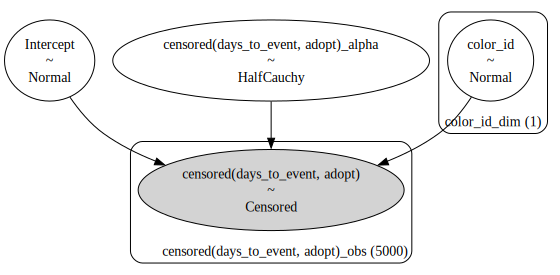

In [48]:
model = bmb.Model(
    "censored(days_to_event, adopt) ~ 1 + color_id", 
    # cats_new,
    data=cats_sample,
    center_predictors=False,
    categorical=["color_id"],
    family="weibull",
    link="log"
)
model.build()
model.graph()

In [49]:
idata = model.fit(tune=500, draws=500, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(days_to_event, adopt)_alpha, Intercept, color_id]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [50]:
az.summary(idata)

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.663,0.056,4.554,4.763,0.002,0.001,936.0,1231.0,1.0
color_id[1],0.050,0.107,-0.128,0.267,0.003,0.002,1275.0,1416.0,1.0
"censored(days_to_event, adopt)_alpha",0.549,0.009,0.531,0.565,0.000,0.000,1034.0,1212.0,1.0


In [51]:
base_rate = idata["posterior"]["censored(days_to_event, adopt)_alpha"]

In [52]:
base_rate.mean(("chain", "draw"))

<xarray.DataArray 'censored(days_to_event, adopt)_alpha' ()>
array(0.54862793)

## PyMC implementation

In [53]:
dm = model.response_component.design
dm

DesignMatrices

                  (rows, cols)
Response:            (5000, 2)
Common:              (5000, 2)

Use .response, .common, or .group to access the different members.

In [54]:
def censored_regression(x, y, lower, upper):

    with pm.Model() as model:
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)
        sigma = pm.HalfCauchy("sigma", beta=1.)

        mu = intercept + x * beta
        # log_mu = pm.math.log(mu)
        y_latent = pm.Weibull.dist(alpha=mu, beta=sigma)
        y_obs = pm.Censored("obs", y_latent, lower=lower, upper=upper, observed=y)

    return model

In [55]:
x = dm.common.design_matrix[:, 1]
observed = np.squeeze(dm.response.design_matrix[:, 0])
censoring_code = np.squeeze(dm.response.design_matrix[:, 1])

is_left_censored = censoring_code == -1
is_right_censored = censoring_code == 1

lower = np.where(is_left_censored, observed, -np.inf)
upper = np.where(is_right_censored, observed, np.inf)

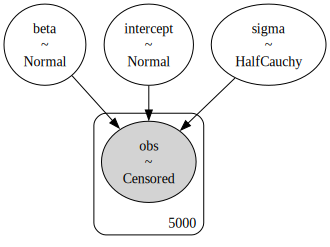

In [56]:
censored_model = censored_regression(x, observed, lower, upper)
censored_model.to_graphviz()

In [38]:
with censored_model:
    trace = pm.sample(200, tune=200, cores=10, random_seed=42)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [intercept, beta, sigma]


Sampling 10 chains for 200 tune and 200 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.


In [39]:
az.summary(trace)

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.492,0.160,0.013,0.560,0.049,0.036,33.0,10.0,1.23
beta,0.127,0.291,-0.007,0.997,0.090,0.066,32.0,319.0,1.26
sigma,56.164,18.621,0.733,65.987,5.727,4.167,33.0,10.0,1.23


## Tests model

In [67]:
def kidney_model(x1, x2, y, lower, upper):
    with pm.Model() as kidney_model:
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
        beta_2 = pm.Normal("beta_2", mu=0, sigma=10)
        alpha = pm.Gamma("alpha", alpha=3, beta=5)

        mu = intercept + beta_1 * x1 + beta_2 * x2
        # log_mu = pm.math.log(mu)
        stateless_dist = pm.Weibull.dist(alpha=alpha, beta=5)

        obs = pm.Censored("obs", stateless_dist, lower=lower, upper=upper, observed=y)
    
    return kidney_model

In [55]:
data = bmb.load_data("kidney")
data["status"] = np.where(data["censored"] == 0, "none", "right")

# Model 1, with intercept
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "sex": bmb.Prior("Normal", mu=0, sigma=2),
    "age": bmb.Prior("Normal", mu=0, sigma=1),
    "alpha": bmb.Prior("Gamma", alpha=3, beta=5),
}
model = bmb.Model(
    "censored(time, status) ~ 1 + sex + age", 
    data, 
    family="weibull", 
    link="log", 
    priors=priors,
    center_predictors=False
)
model.build()
idata = model.fit(tune=250, draws=250, random_seed=121195)

Only 250 samples in chain.


likelihood dist.: <class 'pymc.distributions.continuous.Weibull'>
dims: ('censored(time, status)_obs',)
data_matrix: [[  8   0]
 [ 23   0]
 [ 22   0]
 [447   0]
 [ 30   0]
 [ 24   0]
 [  7   0]
 [511   0]
 [ 53   0]
 [ 15   0]
 [  7   0]
 [141   0]
 [ 96   0]
 [536   0]
 [ 17   0]
 [185   0]
 [292   0]
 [ 15   0]
 [152   0]
 [402   0]
 [ 13   0]
 [ 39   0]
 [ 12   0]
 [132   0]
 [ 34   0]
 [  2   0]
 [130   0]
 [ 27   0]
 [152   0]
 [190   0]
 [119   0]
 [ 63   0]
 [ 16   0]
 [ 28   0]
 [318   0]
 [ 12   0]
 [245   0]
 [  9   0]
 [ 30   0]
 [196   0]
 [154   0]
 [333   0]
 [ 38   0]
 [177   0]
 [114   0]
 [562   0]
 [ 66   0]
 [ 40   0]
 [201   0]
 [156   0]
 [ 30   0]
 [ 25   0]
 [ 26   0]
 [ 58   0]
 [ 43   0]
 [ 30   0]
 [  8   0]
 [ 78   0]
 [149   1]
 [ 22   1]
 [113   1]
 [  5   1]
 [ 54   1]
 [  6   1]
 [ 13   1]
 [  8   1]
 [ 70   1]
 [ 25   1]
 [  4   1]
 [159   1]
 [108   1]
 [ 24   1]
 [ 46   1]
 [  5   1]
 [ 16   1]
 [  8   1]]
observed: [  8  23  22 447  30  24   7 511  53

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(time, status)_alpha, Intercept, sex, age]


Sampling 4 chains for 250 tune and 250 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [56]:
az.summary(idata)

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.476,0.398,3.751,5.235,0.018,0.013,481.0,397.0,1.01
sex[male],-0.935,0.330,-1.509,-0.313,0.013,0.010,675.0,607.0,1.01
age,0.014,0.010,-0.002,0.034,0.000,0.000,451.0,472.0,1.01
"censored(time, status)_alpha",0.859,0.082,0.710,1.012,0.003,0.002,711.0,620.0,1.02


In [58]:
idata["posterior"]

<xarray.Dataset>
Dimensions:                       (chain: 4, draw: 250, sex_dim: 1)
Coordinates:
  * chain                         (chain) int64 0 1 2 3
  * draw                          (draw) int64 0 1 2 3 4 ... 245 246 247 248 249
  * sex_dim                       (sex_dim) <U4 'male'
Data variables:
    Intercept                     (chain, draw) float64 3.799 5.077 ... 4.09
    sex                           (chain, draw, sex_dim) float64 -0.9636 ... ...
    age                           (chain, draw) float64 0.029 ... 0.02918
    censored(time, status)_alpha  (chain, draw) float64 0.8367 0.8161 ... 0.8181
Attributes:
    created_at:                  2023-10-17T07:35:33.970929
    arviz_version:               0.16.1
    inference_library:           pymc
    inference_library_version:   5.8.1
    sampling_time:               1.5650150775909424
    tuning_steps:                250
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0.dev